<a href="https://www.kaggle.com/code/salilapte/data-mining-comment-classifier?scriptVersionId=212252824" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [4]:
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import re  # For regular expressions in text cleaning
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For advanced visualizations
from sklearn.feature_extraction.text import TfidfVectorizer  # For TF-IDF vectorization
from sklearn.model_selection import train_test_split  # For splitting the dataset
from sklearn.linear_model import LogisticRegression  # For Logistic Regression model
from sklearn.model_selection import KFold # For K-Fold model optimization
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)  # For model evaluation metrics

974470
Missing Values:
 text         0
generated    0
dtype: int64

Class Distribution:
 generated
0.0    305797
1.0    181438
Name: count, dtype: int64

Text Length Statistics:
 count    487235.000000
mean       2269.586592
std         988.814028
min           1.000000
25%        1583.000000
50%        2102.000000
75%        2724.000000
max       18322.000000
Name: text_length, dtype: float64
                                                text  \
0  Cars. Cars have been around since they became ...   
1  Transportation is a large necessity in most co...   
2  "America's love affair with it's vehicles seem...   
3  How often do you ride in a car? Do you drive a...   
4  Cars are a wonderful thing. They are perhaps o...   

                                        cleaned_text  
0  cars cars have been around since they became f...  
1  transportation large necessity most countries ...  
2  americas love affair its vehicles seems be coo...  
3  how often do you ride car do you drive one 

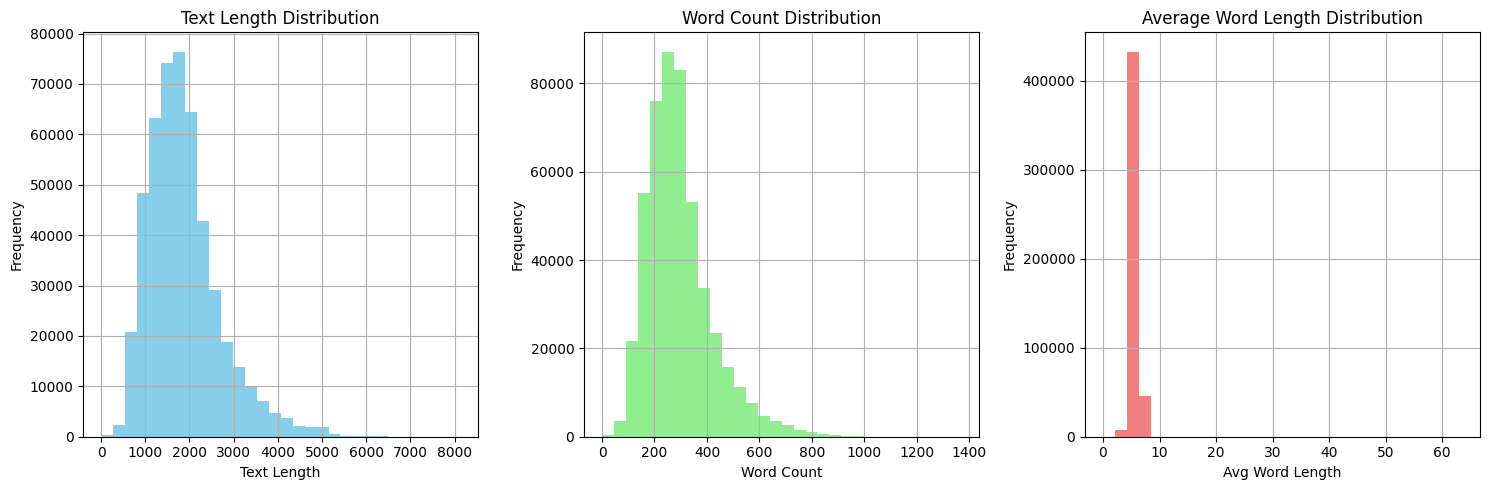


TF-IDF Features (Unigrams and Bigrams):
    able     about  accidents  according    action  activities  activity  \
0   0.0  0.000000        0.0   0.000000  0.000000         0.0  0.000000   
1   0.0  0.057603        0.0   0.000000  0.000000         0.0  0.000000   
2   0.0  0.015019        0.0   0.095195  0.033244         0.0  0.000000   
3   0.0  0.041003        0.0   0.043315  0.000000         0.0  0.044676   
4   0.0  0.000000        0.0   0.000000  0.000000         0.0  0.000000   

   actually  additionally  advantages  ...  years       you  you are  you can  \
0   0.00000      0.000000    0.000000  ...    0.0  0.035298      0.0      0.0   
1   0.00000      0.000000    0.000000  ...    0.0  0.027184      0.0      0.0   
2   0.00000      0.029097    0.059461  ...    0.0  0.042525      0.0      0.0   
3   0.03736      0.000000    0.081167  ...    0.0  0.174145      0.0      0.0   
4   0.00000      0.000000    0.052994  ...    0.0  0.050534      0.0      0.0   

   you have  you sho

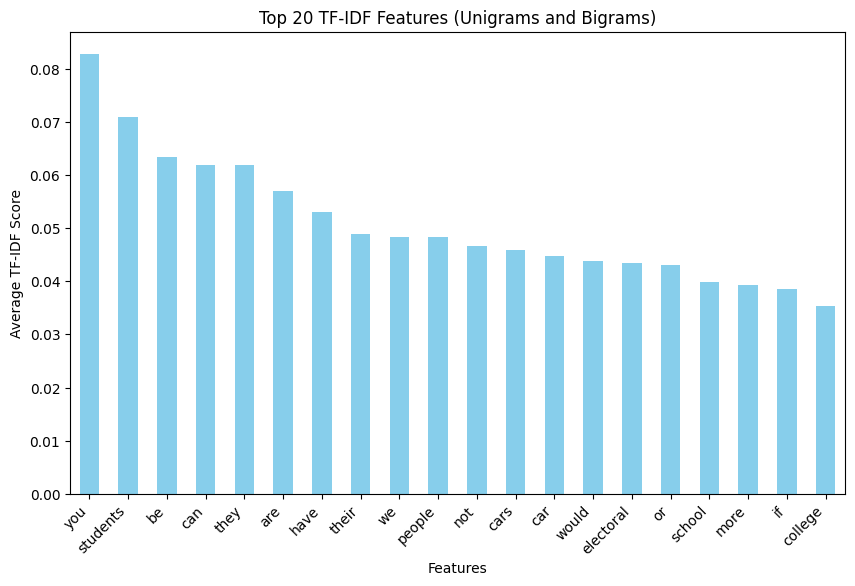

Logistic Regression Accuracy: 0.9943148583332478
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     61112
         1.0       1.00      0.99      0.99     36335

    accuracy                           0.99     97447
   macro avg       0.99      0.99      0.99     97447
weighted avg       0.99      0.99      0.99     97447

Accuracy with Heuristic Fix: 0.9822467597771096
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     61112
         1.0       0.96      0.99      0.98     36335

    accuracy                           0.98     97447
   macro avg       0.98      0.98      0.98     97447
weighted avg       0.98      0.98      0.98     97447



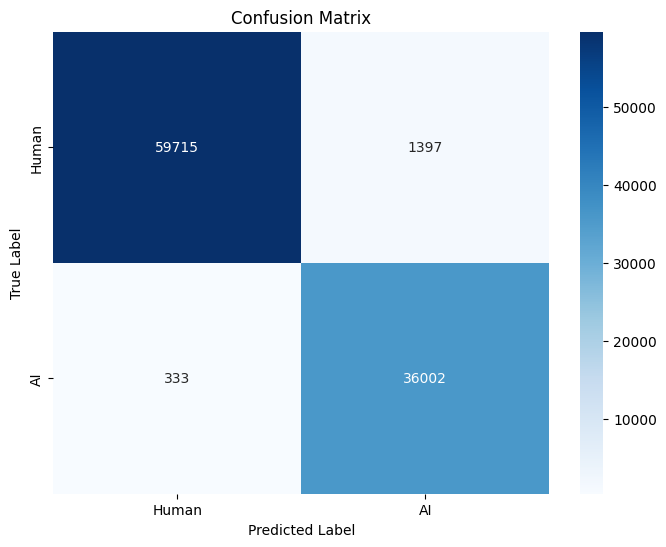

In [2]:
# Load the dataset
df = pd.read_csv('/kaggle/input/ai-human/AI_Human.csv')

# Total entries
print(df.count().sum())

# A brief overview
df.describe()

# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Class distribution in 'generated' column
class_distribution = df['generated'].value_counts()
print("\nClass Distribution:\n", class_distribution)

# Text length analysis
df['text_length'] = df['text'].apply(len)
# Summary statistics for text length
text_length_stats = df['text_length'].describe()
print("\nText Length Statistics:\n", text_length_stats)

# Function to clean text without NLTK
def clean_text_no_nltk(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove simple stopwords manually
    stop_words = {'the', 'and', 'is', 'in', 'to', 'of', 'for', 'it', 'on', 'this', 'that', 'with', 'a', 'as'}
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a cleaned string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply the cleaning function to the 'text' column
df['cleaned_text'] = df['text'].apply(clean_text_no_nltk)

# Display the first few rows to verify cleaning
print(df[['text', 'cleaned_text']].head())

# Text length features
df['text_length'] = df['cleaned_text'].apply(len)
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
df['avg_word_length'] = df['cleaned_text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)

# Display the new features
print(df[['text_length', 'word_count', 'avg_word_length']].head())

# Plot histograms for each feature
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['text_length'].hist(bins=30, color='skyblue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
df['word_count'].hist(bins=30, color='lightgreen')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
df['avg_word_length'].hist(bins=30, color='lightcoral')
plt.title('Average Word Length Distribution')
plt.xlabel('Avg Word Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Extracting unigrams and bigrams using TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Convert the TF-IDF matrix to a DataFrame for easier interpretation
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the top features (unigrams and bigrams)
print("\nTF-IDF Features (Unigrams and Bigrams):\n", tfidf_df.head())

# Compute the average TF-IDF score for each feature
tfidf_mean = tfidf_df.mean().sort_values(ascending=False)

# Select the top 20 features
top_features = tfidf_mean.head(20)

# Plot the top features
plt.figure(figsize=(10, 6))
top_features.plot(kind='bar', color='skyblue')
plt.title('Top 20 TF-IDF Features (Unigrams and Bigrams)')
plt.ylabel('Average TF-IDF Score')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.show()

# Vectorize text data
vectorizer = TfidfVectorizer(max_features=5000)  # Reduce features for efficiency
X = vectorizer.fit_transform(df['text'])
y = df['generated']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
log_model = LogisticRegression(max_iter=1000, solver='liblinear')  # Ensure solver compatibility
log_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = log_model.predict(X_test)
y_score = log_model.decision_function(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Enhanced preprocessing function
def clean_text_enhanced(text):
    text = text.lower()
    # Remove only special characters, but keep punctuation
    text = re.sub(r'[^a-z\s.,;:!?]', '', text)
    return text

# Heuristic fix function
def heuristic_fix(text, prediction):
    human_keywords = ['virtue', 'nation', 'manly', 'citizen', 'flag', 'freedom']
    if sum(word in text.lower() for word in human_keywords) >= 3:
        return 0  # Bias towards "Human"
    return prediction

# Prediction and evaluation with heuristic fix
def predict_with_heuristic(input_text):
    cleaned_text = clean_text_enhanced(input_text)
    vectorized_text = vectorizer.transform([cleaned_text])
    raw_prediction = log_model.predict(vectorized_text)[0]
    return heuristic_fix(input_text, raw_prediction)

# Evaluate on test data
y_pred = []
for text in X_test:
    raw_text = vectorizer.inverse_transform(text)[0]  # Extract raw text from the vectorized input
    y_pred.append(predict_with_heuristic(' '.join(raw_text)))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with Heuristic Fix: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# # **Visualization 1: Confusion Matrix**
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(6, 4))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

# # **Visualization 2: ROC Curve**
# fpr, tpr, _ = roc_curve(y_test, y_score)
# roc_auc = auc(fpr, tpr)
# plt.figure(figsize=(6, 4))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.title('ROC Curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.legend(loc="lower right")
# plt.show()

# # **Visualization 3: Precision-Recall Curve**
# precision, recall, _ = precision_recall_curve(y_test, y_score)
# plt.figure(figsize=(6, 4))
# plt.plot(recall, precision, marker='.', label='Precision-Recall')
# plt.fill_between(recall, precision, alpha=0.3, color='blue')
# plt.title('Precision-Recall Curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.legend()
# plt.show()

# # **Visualization 4: Top Positive and Negative Features**
# # Extract feature coefficients
# feature_names = vectorizer.get_feature_names_out()
# coefficients = log_model.coef_[0]

# # Combine features and coefficients into a DataFrame
# coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
# top_positive = coef_df.nlargest(10, 'Coefficient')
# top_negative = coef_df.nsmallest(10, 'Coefficient')

# # Plot top positive coefficients
# plt.figure(figsize=(8, 5))
# sns.barplot(x='Coefficient', y='Feature', data=top_positive, palette='Greens', hue=None)
# plt.legend([], [], frameon=False)  # Explicitly disable the legend
# plt.title('Top 10 Positive Features (AI Indicating Words)')
# plt.xlabel('Coefficient Value')
# plt.ylabel('Feature')
# plt.show()

# # Plot top negative coefficients
# plt.figure(figsize=(8, 5))
# sns.barplot(x='Coefficient', y='Feature', data=top_negative, palette='Reds', hue=None)
# plt.legend([], [], frameon=False)  # Explicitly disable the legend
# plt.title('Top 10 Negative Features (Human Indicating Words)')
# plt.xlabel('Coefficient Value')
# plt.ylabel('Feature')
# plt.show()

# # **Visualization 5: Histogram of Predictions**
# plt.figure(figsize=(6, 4))
# sns.histplot(y_score, kde=True, bins=30, color='purple')
# plt.axvline(0, color='red', linestyle='--', label='Decision Boundary')
# plt.title('Histogram of Decision Function Scores')
# plt.xlabel('Decision Score')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

In [5]:
# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000, solver='liblinear')

# Lists to store performance metrics
accuracies = []
precisions = []
recalls = []
roc_aucs = []

print("Performing K-Fold Cross-Validation...")

# Perform K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC
    
    # Evaluate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Store metrics
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    roc_aucs.append(roc_auc)
    
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, ROC AUC: {roc_auc:.4f}")
    print("-" * 50)

# Print average metrics
print("\nK-Fold Cross-Validation Results:")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"ROC AUC: {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}")

# Train the final model on the entire dataset (if needed)
model.fit(X, y)
print("\nFinal Model Trained on Full Dataset")

Performing K-Fold Cross-Validation...
Fold 1
Accuracy: 0.9943, Precision: 0.9966, Recall: 0.9881, ROC AUC: 0.9995
--------------------------------------------------
Fold 2
Accuracy: 0.9941, Precision: 0.9953, Recall: 0.9889, ROC AUC: 0.9995
--------------------------------------------------
Fold 3
Accuracy: 0.9944, Precision: 0.9959, Recall: 0.9890, ROC AUC: 0.9995
--------------------------------------------------
Fold 4
Accuracy: 0.9942, Precision: 0.9952, Recall: 0.9891, ROC AUC: 0.9995
--------------------------------------------------
Fold 5
Accuracy: 0.9946, Precision: 0.9963, Recall: 0.9891, ROC AUC: 0.9994
--------------------------------------------------

K-Fold Cross-Validation Results:
Accuracy: 0.9943 ± 0.0002
Precision: 0.9959 ± 0.0005
Recall: 0.9889 ± 0.0004
ROC AUC: 0.9995 ± 0.0000

Final Model Trained on Full Dataset


In [6]:
import pickle

# Save the trained Logistic Regression model
with open("log_model.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

# Save the trained TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)